In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from fastai.vision import *

path = untar_data(URLs.CAMVID)
print(path.ls()) # prints subdirectories

[PosixPath('/home/evlavrukhin/.fastai/data/camvid/images'), PosixPath('/home/evlavrukhin/.fastai/data/camvid/codes.txt'), PosixPath('/home/evlavrukhin/.fastai/data/camvid/labels'), PosixPath('/home/evlavrukhin/.fastai/data/camvid/valid.txt')]


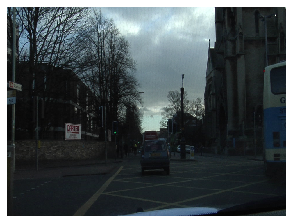

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# open and show image
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [4]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

print(get_y_fn(img_f))

/home/evlavrukhin/.fastai/data/camvid/labels/0001TP_007020_P.png


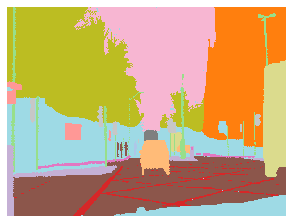

In [5]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [21]:
with open('/home/evlavrukhin/.fastai/data/camvid/codes.txt', 'r') as f:
    codes = [item.strip() for item in f.readlines()]

In [23]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs = 2

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       .split_by_fname_file('../valid.txt')
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

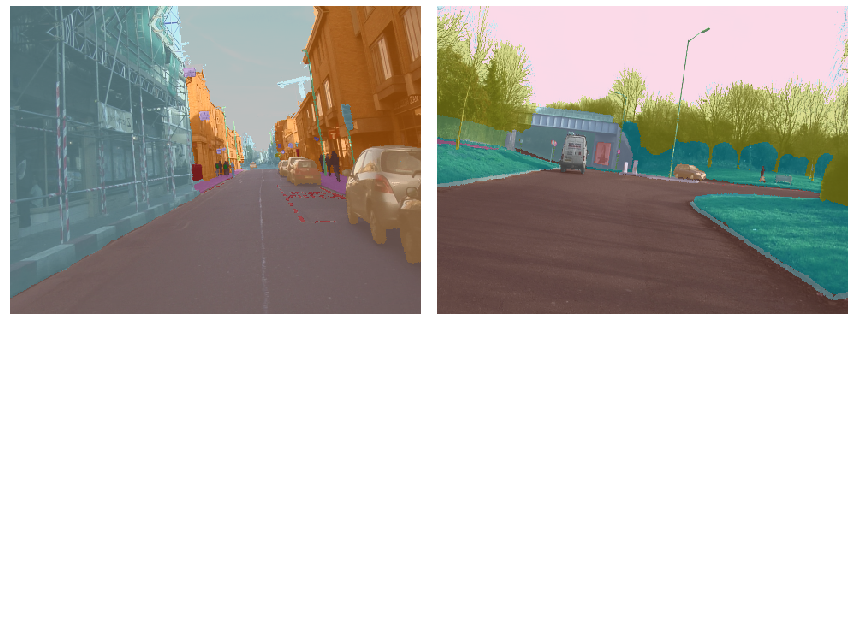

In [24]:
data.show_batch(rows=3, figsize=(12, 9))

In [26]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [28]:
learn = unet_learner(data, models.resnet34, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/evlavrukhin/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:08<00:00, 10.9MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


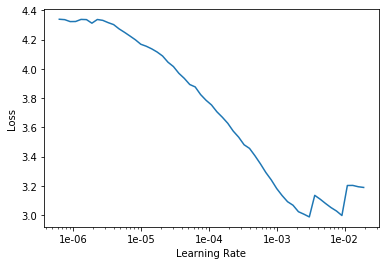

In [29]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [30]:
lr = 3e-3 # pick a lr
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) # train model

epoch,train_loss,valid_loss,time
0,0.812493,0.644161,00:47
1,0.681283,0.526719,00:45
2,0.666110,0.654545,00:45
3,0.615232,0.484076,00:45
4,0.576434,0.557047,00:45
5,0.565713,0.436629,00:45
6,0.629725,0.524339,00:45
7,0.591381,0.450703,00:45
8,0.564906,0.475180,00:45
9,0.469703,0.347951,00:45


In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch256'
data_conf['patches'] = {
    'train': (256, 256, 1),
    'val': (256, 256, 1),
    'test': (256, 256, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch256',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test':

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 256
aug_config['original_width'] = 256
aug_config

{'aug_type': 'soft', 'original_height': 256, 'original_width': 256, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 6, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 6,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 24
dataloaders_conf['val']['batch_size'] = 24
dataloaders_conf['test']['batch_size'] = 24
dataloaders_conf

{'train': {'batch_size': 24, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 24, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 24, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 672.80it/s]
100%|██████████| 720/720 [00:07<00:00, 93.29it/s] 
2070it [00:00, 250034.83it/s]
1980it [00:00, 242197.85it/s]
700it [00:00, 774.91it/s]
100%|██████████| 700/700 [00:07<00:00, 99.81it/s] 
2070it [00:00, 259031.25it/s]
1980it [00:00, 234656.32it/s]
710it [00:00, 760.89it/s]
100%|██████████| 710/710 [00:07<00:00, 96.53it/s] 
1980it [00:00, 254730.44it/s]
1890it [00:00, 232381.63it/s]
720it [00:00, 825.09it/s]
100%|██████████| 720/720 [00:07<00:00, 96.90it/s] 
2070it [00:00, 234533.87it/s]
720it [00:00, 857.90it/s]
100%|██████████| 720/720 [00:07<00:00, 93.37it/s] 
6480it [00:00, 210579.62it/s]
700it [00:00, 764.16it/s]
100%|██████████| 700/700 [00:06<00:00, 100.80it/s]
6300it [00:00, 193512.38it/s]
509it [00:00, 1129.25it/s]
100%|██████████| 509/509 [00:02<00:00, 194.33it/s]
2036it [00:00, 233788.78it/s]
700it [00:00, 853.84it/s]
100%|██████████| 700/700 [00:06<00:00, 101.66it/s]
6300it [00:00, 200348.13it/s]
700it [00:00, 835.47it/s]
100%|██████████| 700/700 [0

In [15]:
len(data_train), len(data_val), len(data_test)

(6120, 5850, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.72944


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.261
Epoch 1...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.17199


100%|██████████| 244/244 [00:26<00:00,  9.23it/s]


Mean val loss: 0.13987


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.098542


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.34579
EarlyStopping counter: 1 out of 15
Epoch 3...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.076526


100%|██████████| 244/244 [00:25<00:00,  9.39it/s]


Mean val loss: 0.080949


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.066444


100%|██████████| 244/244 [00:25<00:00,  9.46it/s]


Mean val loss: 0.06424


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.059498


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.069488
EarlyStopping counter: 1 out of 15
Epoch 6...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.057158


100%|██████████| 244/244 [00:25<00:00,  9.44it/s]


Mean val loss: 0.053677


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.053781


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.065117
EarlyStopping counter: 1 out of 15
Epoch 8...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.052441


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.065796
EarlyStopping counter: 2 out of 15
Epoch 9...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.050273


100%|██████████| 244/244 [00:25<00:00,  9.56it/s]


Mean val loss: 0.051005


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 10...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04987


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.060772
EarlyStopping counter: 1 out of 15
Epoch 11...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.048899


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.052749
EarlyStopping counter: 2 out of 15
Epoch 12...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.047947


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.063008
EarlyStopping counter: 3 out of 15
Epoch 13...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04775


100%|██████████| 244/244 [00:25<00:00,  9.57it/s]


Mean val loss: 0.048492


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.046942


100%|██████████| 244/244 [00:26<00:00,  9.16it/s]


Mean val loss: 0.048042


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.046153


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.062085
EarlyStopping counter: 1 out of 15
Epoch 16...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.046499


100%|██████████| 244/244 [00:25<00:00,  9.71it/s]


Mean val loss: 0.046415


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.045088


100%|██████████| 244/244 [00:25<00:00,  9.40it/s]


Mean val loss: 0.045545


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 18...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.045547


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.051618
EarlyStopping counter: 1 out of 15
Epoch 19...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.045071


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.048008
EarlyStopping counter: 2 out of 15
Epoch 20...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.045406


100%|██████████| 244/244 [00:26<00:00,  9.13it/s]


Mean val loss: 0.045306


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.044767


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.10327
EarlyStopping counter: 1 out of 15
Epoch 22...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.044542


100%|██████████| 244/244 [00:25<00:00,  9.39it/s]


Mean val loss: 0.044104


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 23...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.043763


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.049056
EarlyStopping counter: 1 out of 15
Epoch 24...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.043889


100%|██████████| 244/244 [00:26<00:00,  9.31it/s]


Mean val loss: 0.043871


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 25...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.043706


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.045433
EarlyStopping counter: 1 out of 15
Epoch 26...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.044053


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.044012
EarlyStopping counter: 2 out of 15
Epoch 27...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.042995


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.046024
EarlyStopping counter: 3 out of 15
Epoch 28...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.042762


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.045055
EarlyStopping counter: 4 out of 15
Epoch 29...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04267


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.050214
EarlyStopping counter: 5 out of 15
Epoch 30...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.042589


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.045261
EarlyStopping counter: 6 out of 15
Epoch 31...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.042318


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.045163
EarlyStopping counter: 7 out of 15
Epoch 32...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041989


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.0473
EarlyStopping counter: 8 out of 15
Epoch 33...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041793


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.044132
EarlyStopping counter: 9 out of 15
Epoch 34...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.042092


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.05105
EarlyStopping counter: 10 out of 15
Epoch 35...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04157


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.048177
EarlyStopping counter: 11 out of 15
Epoch 36...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041706


100%|██████████| 244/244 [00:25<00:00,  9.48it/s]


Mean val loss: 0.043103


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 37...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041448


100%|██████████| 244/244 [00:25<00:00,  9.55it/s]


Mean val loss: 0.042687


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 38...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041393


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.044038
EarlyStopping counter: 1 out of 15
Epoch 39...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04152


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043841
EarlyStopping counter: 2 out of 15
Epoch 40...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041132


100%|██████████| 244/244 [00:25<00:00,  9.44it/s]


Mean val loss: 0.042592


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04164


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043204
EarlyStopping counter: 1 out of 15
Epoch 42...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040971


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.046409
EarlyStopping counter: 2 out of 15
Epoch 43...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040849


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.050145
EarlyStopping counter: 3 out of 15
Epoch 44...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040768


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.046797
EarlyStopping counter: 4 out of 15
Epoch 45...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040728


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043935
EarlyStopping counter: 5 out of 15
Epoch 46...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040685


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043942
EarlyStopping counter: 6 out of 15
Epoch 47...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040702


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043262
EarlyStopping counter: 7 out of 15
Epoch 48...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04041


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.04457
EarlyStopping counter: 8 out of 15
Epoch 49...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040518


100%|██████████| 244/244 [00:26<00:00,  9.33it/s]


Mean val loss: 0.041594


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04045


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.056084
EarlyStopping counter: 1 out of 15
Epoch 51...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040314


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.047489
EarlyStopping counter: 2 out of 15
Epoch 52...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040268


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.054222
EarlyStopping counter: 3 out of 15
Epoch 53...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040063


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042829
EarlyStopping counter: 4 out of 15
Epoch 54...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039916


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.044039
EarlyStopping counter: 5 out of 15
Epoch 55...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03997


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042193
EarlyStopping counter: 6 out of 15
Epoch 56...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040432


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043361
EarlyStopping counter: 7 out of 15
Epoch 57...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039955


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043195
EarlyStopping counter: 8 out of 15
Epoch 58...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040041


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.044104
EarlyStopping counter: 9 out of 15
Epoch 59...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039998


100%|██████████| 244/244 [00:25<00:00,  9.55it/s]


Mean val loss: 0.041515


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 60...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039645


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.046
EarlyStopping counter: 1 out of 15
Epoch 61...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039731


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.045803
EarlyStopping counter: 2 out of 15
Epoch 62...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039612


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.041757
EarlyStopping counter: 3 out of 15
Epoch 63...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039605


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.047974
EarlyStopping counter: 4 out of 15
Epoch 64...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03945


100%|██████████| 244/244 [00:25<00:00,  9.50it/s]


Mean val loss: 0.041453


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 65...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040039


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.041597
EarlyStopping counter: 1 out of 15
Epoch 66...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039467


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.0433
EarlyStopping counter: 2 out of 15
Epoch 67...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039634


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042595
EarlyStopping counter: 3 out of 15
Epoch 68...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039302


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042398
EarlyStopping counter: 4 out of 15
Epoch 69...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039536


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.041551
EarlyStopping counter: 5 out of 15
Epoch 70...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039197


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042692
EarlyStopping counter: 6 out of 15
Epoch 71...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039168


100%|██████████| 244/244 [00:26<00:00,  9.16it/s]


Mean val loss: 0.040919


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 72...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039506


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.050387
EarlyStopping counter: 1 out of 15
Epoch 73...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039438


100%|██████████| 244/244 [00:26<00:00,  9.21it/s]


Mean val loss: 0.040549


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 74...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03912


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.043818
EarlyStopping counter: 1 out of 15
Epoch 75...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039082


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.041966
EarlyStopping counter: 2 out of 15
Epoch 76...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039297


100%|██████████| 244/244 [00:25<00:00,  9.48it/s]


Mean val loss: 0.040411


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 77...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038833


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.04158
EarlyStopping counter: 1 out of 15
Epoch 78...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039035


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.040518
EarlyStopping counter: 2 out of 15
Epoch 79...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038888


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.041287
EarlyStopping counter: 3 out of 15
Epoch 80...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038871


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.041266
EarlyStopping counter: 4 out of 15
Epoch 81...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03892


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042166
EarlyStopping counter: 5 out of 15
Epoch 82...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.039019


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.040851
EarlyStopping counter: 6 out of 15
Epoch 83...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038762


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042133
EarlyStopping counter: 7 out of 15
Epoch 84...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038958


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.048489
EarlyStopping counter: 8 out of 15
Epoch 85...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038535


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042332
EarlyStopping counter: 9 out of 15
Epoch 86...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038479


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.042055
EarlyStopping counter: 10 out of 15
Epoch 87...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038548


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.046562
EarlyStopping counter: 11 out of 15
Epoch 88...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038557


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.047242
EarlyStopping counter: 12 out of 15
Epoch 89...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038486


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.067259
EarlyStopping counter: 13 out of 15
Epoch 90...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038646


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.060653
EarlyStopping counter: 14 out of 15
Epoch 91...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038569


  0%|          | 0/87 [00:00<?, ?it/s]

Mean val loss: 0.056857
EarlyStopping counter: 15 out of 15


 95%|█████████▌| 83/87 [02:47<00:07,  1.99s/it]

## Dump experiment results

In [ ]:
import pickle
import json

In [ ]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [ ]:
from itertools import chain

In [ ]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [ ]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [ ]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [ ]:
import pandas as pd

In [ ]:
from visualization_utils import make_df

In [ ]:
df = make_df(results, model_name='basic')
df

In [ ]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

## Check loss to loss ratio

In [ ]:
criterion.losses

In [ ]:
from stack_segmentation.training import make_joint_loss

In [ ]:
import torch

In [ ]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [ ]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [ ]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))